In [1]:
import argparse
import re
import time
from itertools import izip, cycle
import functools

import numpy as np
import Ska.DBI
from astropy.table import Table, vstack
from astropy.time import Time
import mica.archive.obspar
from mica.archive import asp_l1
import Ska.Shell
from Ska.quatutil import yagzag2radec
from Quaternion import Quat
from Ska.quatutil import radec2yagzag

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
FIDS = {'ACIS-S': [1, 2, 3, 4, 5, 6],
        'ACIS-I': [1, 2, 3, 4, 5, 6],
        'HRC-I': [7, 8, 9, 10],
        'HRC-S': [11, 12, 13, 14],
        }

In [49]:
aimpoint_data_cache = {}
acis_pixscale = 0.492  # arcsec / pixel

def get_aimpoint_data(det):
    """
    Read aimpoint data provided by P. Zhao and define additional columns
    that make it easier to compare with fid light drift data.
    """
    if det not in aimpoint_data_cache:
        filename = '{}_ap_pos.rdb'.format(re.sub(r'-', '', det).lower())
        dat = Table.read(filename, format='ascii.rdb')
        y_off = dat['y_det_offset'] * 60 / acis_pixscale  # pix / arcmin
        z_off = dat['z_det_offset'] * 60 / acis_pixscale  # pix / arcmin
        if det == 'ACIS-S':
            dat['target_chipx'] = dat['dmt_chipx'] + y_off
            dat['target_chipy'] = dat['dmt_chipy'] + z_off
            dat['target_sim_y'] = dat['target_chipx'] * acis_pixscale
            dat['target_sim_z'] = dat['target_chipy'] * acis_pixscale
            dat['opt_axis_sim_y'] = dat['dmp_chipx'] * acis_pixscale
            dat['opt_axis_sim_z'] = dat['dmp_chipy'] * acis_pixscale
        elif det == 'ACIS-I':
            dat['target_chipx'] = dat['dmt_chipx'] + z_off
            dat['target_chipy'] = dat['dmt_chipy'] - y_off
            dat['target_sim_y'] = -dat['target_chipy'] * acis_pixscale
            dat['target_sim_z'] = dat['target_chipx'] * acis_pixscale
            dat['opt_axis_sim_y'] = -dat['dmp_chipy'] * acis_pixscale
            dat['opt_axis_sim_z'] = dat['dmp_chipx'] * acis_pixscale
        else:
            raise ValueError('Only ACIS-S and ACIS-I are supported here')

        aimpoint_data_cache[det] = dat
    return aimpoint_data_cache[det]    

In [50]:
fid_stats_cache = {}

def get_fid_stats(det):
    """
    Get fid light drift data from Sybase fid_stats table.  This corrects
    the data for SIM-Z offset as well as the nominal SIM-Z for each detector.
    """
    if det not in fid_stats_cache:
        EXCLUDE_OBSIDS = '(2010, 2783, 1431, 1411)'
        
        db = Ska.DBI.DBI(dbi='sybase', server='sybase', user='aca_read')
        query = ('select obsid, id_num, id_string, tstart, ang_y_med, ang_z_med, sim_z_offset'
                 ' FROM fid_stats'
                 ' WHERE proc_status IS NULL AND id_string LIKE "{}%" '
                 ' and obsid not in {} '
                 .format(det, EXCLUDE_OBSIDS))
        vals = Table(db.fetchall(query))
        db.conn.close()
        
        vals['ang_y_norm'] = -9999.0
        vals['ang_z_norm'] = -9999.0
        
        sim_z_nom = np.median(vals['sim_z_offset'])
        vals['year'] = Time(vals['tstart'], format='cxcsec').decimalyear
        for fid in FIDS[det]:
            fid_idx = np.where(vals['id_num'] == fid)
            fs = vals[fid_idx]
            year = vals['year'][fid_idx]
            
            ang_y_corr = fs['ang_y_med']
            ang_z_corr = fs['ang_z_med'] + fs['sim_z_offset'] - sim_z_nom

            year_ok = (year > 2002) & (year < 2003)
            if np.count_nonzero(year_ok) < 3:
                print('Fid %s %d' % (det, fid))
                print('Not enough readouts for the median')
                continue
            y0 = np.median(ang_y_corr[year_ok])
            z0 = np.median(ang_z_corr[year_ok])
            vals['ang_y_norm'][fid_idx] = ang_y_corr - y0
            vals['ang_z_norm'][fid_idx] = ang_z_corr - z0
        
        fid_stats_cache[det] = vals
    
    return fid_stats_cache[det]

In [51]:
def plot_fid_drift_vs_year(detstats, det):
    """
    Plot fid drift data for specified detector.
    """
    year0 = 0.
    fidcolor = ' bgrcmkbgrcbgrc'
    plt.figure(figsize=(6, 4.5))
    plt.clf()
    plt.subplot(2, 1, 1)
    plt.ylabel('Y offset (arcsec)')
    maxyear = int(time.strftime('%Y')) + 1
    DEFAULT_MIN = -25 # arcsec
    plt.axis([1999, maxyear, DEFAULT_MIN, 10])
    plt.title(det + ' Fid Drift')
    plt.grid()
    plt.subplot(2, 1, 2)
    plt.xlabel('Year')  # MET (years)')
    plt.ylabel('Z offset (arcsec)')
    plt.axis([1999, maxyear, DEFAULT_MIN, 10])
    plt.grid()
    min_plot_y = DEFAULT_MIN
    for fid in FIDS[det]:
        fidstats = detstats[detstats['id_num'] == fid]
        year = fidstats['year']
        fid_min_y = np.min(fidstats['ang_y_norm'])
        fid_min_z = np.min(fidstats['ang_z_norm'])
        fid_min = np.min([fid_min_y, fid_min_z])
        # if the plot min value is less than we've seen for this detector
        # or less than the default, update the minimum (rounded down to the nearest 5)
        if fid_min < min_plot_y:
            min_plot_y = fid_min - (fid_min % 5)
        plt.subplot(2, 1, 1)
        plt.plot(year - year0, fidstats['ang_y_norm'],
                 '.', markersize=4, markerfacecolor=fidcolor[fid], mew=0,
                 scaley=False, scalex=False)
        plt.ylim(ymin=min_plot_y)
        plt.subplot(2, 1, 2)
        plt.plot(year - year0, fidstats['ang_z_norm'],
                 '.', markersize=4, markerfacecolor=fidcolor[fid], mew=0,
                 scaley=False, scalex=False)
        plt.ylim(ymin=min_plot_y)

In [6]:
def plot_aimpoint_vs_year(det, w=None, ref_pos='target'):
    """
    Plot aimpoint data vs time for specified detector.
    """
    dat = get_aimpoint_data(det)
    ok = (dat['year'] > 2002.0) & (dat['year'] < 2003.)
    sc_y0 = np.median(dat['{}_sim_y'.format(ref_pos)][ok])
    sc_z0 = np.median(dat['{}_sim_z'.format(ref_pos)][ok])
    y_off = (dat['{}_sim_y'.format(ref_pos)] - sc_y0)
    z_off = (dat['{}_sim_z'.format(ref_pos)] - sc_z0)
    plt.subplot(2, 1, 1)
    plt.plot(dat['year'], y_off + 20, '.', alpha=0.4)
    if w is not None:
        plt.ylim(-w, w)
    plt.subplot(2, 1, 2)
    plt.plot(dat['year'], z_off + 20, '.', alpha=0.4)
    if w is not None:
        plt.ylim(-w, w)

In [7]:
def plot_aimpoint_xy(det='ACIS-S', years=range(1999, 2020), 
                     xlim=(180, 270), ylim=(450, 540)):
    """
    Plot aimpoint chipx and chipy values for ACIS-S over the specified
    time range. Each year of values is plotted in a different color.
    """
    dat = get_aimpoint_data(det)
    colors = ('r', 'g', 'b', 'm', 'k', 'c')
    plt.figure(4, figsize=(5, 5))
    for year, color in izip(years, cycle(colors)):
        ok = (dat['year'] > year) & (dat['year'] < year + 1)
        if np.count_nonzero(ok) > 2:
            x = dat['target_chipx'][ok]
            y = dat['target_chipy'][ok]
            plt.plot(x, y, '.', color=color)
            medok = (x >= xlim[0]) & (x <= xlim[1]) & (y >= ylim[0]) & (y <= ylim[1])
            x_med = np.median(x[medok])
            y_med = np.median(y[medok])
            print('Year: {} Median chipx, chipy = {:.2f}, {:.2f}'.format(year, x_med, y_med))
    plt.xlim(*xlim)
    plt.ylim(*ylim)
    plt.grid()

In [52]:
def plot_fids_and_aimpoints(det='ACIS-S', w=30, ref_pos='target'):
    """
    Make combined plot of fid drift and aimpoint drift, offsetting
    the aimpoint drift by 20 arcsec for visual clarity.
    """
    detstats = get_fid_stats(det)
    plot_fid_drift_vs_year(detstats, det)
    plot_aimpoint_vs_year(det, w, ref_pos)

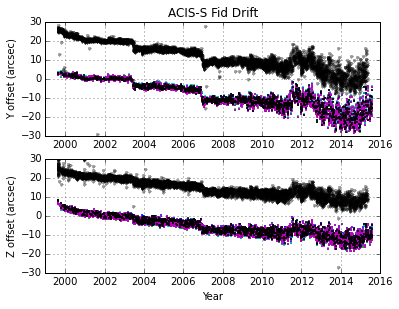

In [9]:
plot_fids_and_aimpoints('ACIS-S', ref_pos='target')

Year: 2013.5 Median chipx, chipy = 204.85, 479.77


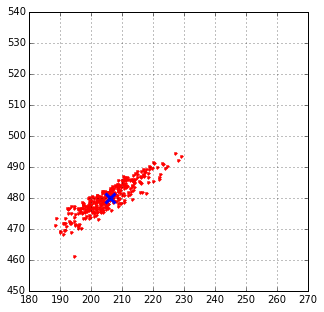

In [11]:
plot_aimpoint_xy(years=(2013.5,))
plt.plot([206], [480], 'xb', ms=10, mew=3);

Year: 2014.5 Median chipx, chipy = 206.40, 480.22


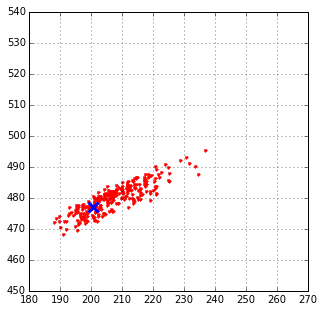

In [12]:
plot_aimpoint_xy(years=(2014.5,))
plt.plot([200.7], [476.9], 'xb', ms=10, mew=3);

In [13]:
dat = get_aimpoint_data('ACIS-S')

Year: 2014.5 Median chipx, chipy = 931.27, 1005.57


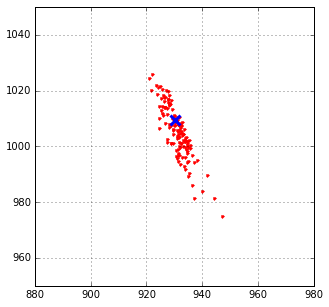

In [14]:
plot_aimpoint_xy(det='ACIS-I', years=(2014.5,), xlim=(880, 980), ylim=(950, 1050))
plt.plot([930.2], [1009.6], 'xb', ms=10, mew=3);

In [53]:
def get_zero_offset_aimpoint_data(det, min_year=2010):
    """
    Return aimpoint data for observations with zero target offset.
    This simplifies the correlation of aspect solution and dmcoords
    results with the published POG plots (chapter 4) of aimpoint drift.
    """
    dat = get_aimpoint_data(det)
    ok = (dat['y_det_offset'] == 0) & (dat['z_det_offset'] == 0) & (dat['year'] > min_year)
    return dat[ok]

In [19]:
dats = get_zero_offset_aimpoint_data('ACIS-S', 2006)
dati = get_zero_offset_aimpoint_data('ACIS-I', 2006)
observations = vstack([dats, dati])

In [20]:
dats[-5:]

obsid,detector,ra_pnt,dec_pnt,ra_targ,dec_targ,sim_x,sim_z,y_det_offset,z_det_offset,dmp_theta,dmp_phi,dmp_skyx,dmp_skyy,dmp_detx,dmp_dety,dmp_chipx,dmp_chipy,dmp_tdetx,dmp_tdety,dmt_theta,dmt_phi,dmt_skyx,dmt_skyy,dmt_detx,dmt_dety,dmt_chipx,dmt_chipy,dmt_tdetx,dmt_tdety,tstart,sched_exp_time,mjdref,ap_chipx,ap_chipy,year,target_chipx,target_chipy,target_sim_y,target_sim_z,opt_axis_sim_y,opt_axis_sim_z
float64,string48,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,string56,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
10825.0,ACIS-S,344.366064988,20.7644294132,344.36625,20.768833,-0.682822524731,-190.142580365,0.0,0.0,0.0,113.74,4096.5,4096.5,4096.5,4096.5,190.69,501.93,4107.69,2203.93,15.9,21.01,4095.23,4128.72,4126.6,4108.06,220.83,490.34,4137.83,2192.34,344948671.064,4800.0,50814.0,220.83,490.34,2008.934262,220.83,490.34,108.64836,241.24728,93.81948,246.94956
11796.0,ACIS-S,324.282586786,0.44298817603,324.284583,0.446944,-0.682822524731,-190.142580365,0.0,0.0,0.0,84.67,4096.5,4096.5,4096.5,4096.5,189.65,501.69,4106.65,2203.69,16.0,21.31,4081.89,4125.45,4126.7,4108.28,219.88,489.87,4136.88,2191.87,369507370.936,25000.0,50814.0,219.88,489.87,2009.7128,219.88,489.87,108.18096,241.01604,93.3078,246.83148
12351.0,ACIS-S,134.772517963,-47.5069750559,134.773333,-47.511361,-0.682822524731,-190.142580365,0.0,0.0,0.0,339.64,4096.5,4096.5,4096.5,4096.5,183.02,493.8,4100.02,2195.8,15.9,21.52,4092.47,4064.41,4126.59,4108.36,213.15,481.91,4130.15,2183.91,402220253.235,54000.0,50814.0,213.15,481.91,2010.749869,213.15,481.91,104.8698,237.09972,90.04584,242.9496
12360.0,ACIS-S,217.401795413,-62.6728282286,217.403933,-62.677144,-0.682822524731,-190.142580365,0.0,0.0,0.0,339.25,4096.5,4096.5,4096.5,4096.5,187.38,494.14,4104.38,2196.14,15.9,21.55,4089.32,4064.92,4126.62,4108.39,217.53,482.22,4134.53,2184.22,408586755.088,79250.0,50814.0,217.53,482.22,2010.952011,217.53,482.22,107.02476,237.25224,92.19096,243.11688
15699.0,ACIS-S,283.596333638,-20.1466612318,283.6127,-20.1692,-0.682822524731,-190.14006605,0.0,0.0,0.0,284.26,4096.5,4096.5,4096.5,4096.5,165.72,482.91,4082.72,2184.91,1.637',329.15,3984.09,3931.58,4267.86,3994.17,337.38,585.27,4254.38,2287.27,509594571.038,35000.0,50814.0,337.38,585.27,2014.152054,337.38,585.27,165.99096,287.95284,81.53424,237.59172


In [21]:
# Define nominal SIM-X and Z positions as median observed values

sim_z_nom = {'ACIS-S': np.median(dats['sim_z']),
             'ACIS-I': np.median(dati['sim_z'])}
sim_x_nom = {'ACIS-S': np.median(dats['sim_x']),
             'ACIS-I': np.median(dati['sim_x'])}
sim_z_nom

{'ACIS-I': -233.58743446082869, 'ACIS-S': -190.14258036517339}

In [22]:
# Use the obspar for each obsid to fill in some additional
# columns.  Yag and Zag represent the local frame position
# (arcsec) of the target in the nominal frame.

noms = ('ra_nom', 'dec_nom', 'roll_nom')
for nom in noms:
    observations[nom] = 0.0
observations['yag'] = 0.0
observations['zag'] = 0.0

for obs in observations:
    obspar = mica.archive.obspar.get_obspar(obs['obsid'])
    for nom in noms:
        obs[nom] = obspar[nom]
    obs['ra_targ'] = obspar['ra_targ']
    obs['dec_targ'] = obspar['dec_targ']
    q_nom = Quat([obs[nom] for nom in noms])
    obs['yag'], obs['zag'] = radec2yagzag(obspar['ra_targ'], obspar['dec_targ'], q_nom)

observations['yag'] *= 3600
observations['zag'] *= 3600

In [54]:
# Look at key columns for the first few obsids

observations[('obsid', 'ra_targ', 'dec_targ') +
             ('ra_pnt', 'dec_pnt') +
             noms + ('yag', 'zag')][:5]

obsid,ra_targ,dec_targ,ra_pnt,dec_pnt,ra_nom,dec_nom,roll_nom,yag,zag
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
6730.0,345.284583,58.879222,345.289911532,58.8826010137,345.289926715,58.8826277602,73.7475041311,-14.5530650439,6.11407278569
7498.0,266.8175,-28.180056,266.817097076,-28.1843528708,266.817097076,-28.1843528708,284.670236772,-14.6406326013,5.15445170116
7638.0,133.3375,-47.335,133.339009477,-47.3306926943,133.339009459,-47.3306925949,98.1577384918,-14.8272114841,5.84583106185
8038.0,193.072917,11.313889,193.074903454,11.3177952436,193.07485495,11.3179100047,86.1021039224,-14.9071539195,5.84118881379
8041.0,189.2225,7.246389,189.218707705,7.24431078376,189.218680502,7.24418952427,231.045064119,-14.7333126246,5.62908071909


In [55]:
def plot_yag_zag(observations, det):
    """
    Plot the local target position in Yag, Zag coordinates
    (referenced to the nominal frame).
    """
    ok = observations['detector'] == det
    plt.plot(observations['yag'][ok], observations['zag'][ok], '.')
    plt.xlim(-18, -12)
    plt.ylim(4, 8)
    plt.grid()
    plt.title(det)
    plt.ylabel('zag (arcsec)')
    plt.xlabel('yag (arcsec)')

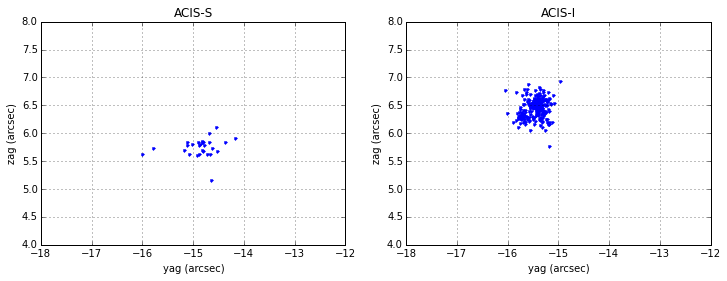

In [27]:
# Now we are convinced that there is a predictable offset
# between the target coordinate and the nominal frame.

plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plot_yag_zag(observations, 'ACIS-S')
plt.subplot(1, 2, 2)
plot_yag_zag(observations, 'ACIS-I')


In [24]:
# Define a fake nominal frame as ra, dec, roll = 0.
# Then define a "zero" target location ra0, dec0 that has
# the same Yag, Zag values 

q0 = Quat([0, 0, 0])
ra0, dec0 = -15.5 / 3600., 6.0 / 3600.
np.array(radec2yagzag(ra0, dec0, q0)) * 3600.

array([-15.5       ,   6.00000002])

### Where does this -15, 6 arcsec offset come from?

It's basically the difference between two rotation matrices in our system:

- `ACA_MISALIGN`: MNC (HRMA optical axis) to ACA frame misalignment.
- `ODB_SI_ALIGN`: Misalignment used to transform from science target coordinates to ACA (PCAD) pointing direction that gets used on-board.

My recollection is that the fact that these are not the same is a relic of a decision during OAC, but I'm not entirely certain of that.

In [63]:

calalign = Table.read('/soft/ciao/CALDB/data/chandra/pcad/align/pcadD2012-09-13alignN0009.fits',
                     hdu='CALALIGN')

In [64]:
calalign

INSTR_ID,"ACA_SC_ALIGN [3,3]","ACA_MISALIGN [3,3]","FTS_MISALIGN [3,3]",LSI0_STT [3],RRC0_FC_X
,,,,mm,mm
string72,float64,float64,float64,float64,float64
ACIS-S,1.0 .. 1.0,0.999999885766 .. 0.999996233612,0.999999987092 .. 0.999995726325,0.0 .. 190.5,10065.5117188
ACIS-I,1.0 .. 1.0,0.999999884457 .. 0.999993337636,0.99999998528 .. 0.999989507649,0.0 .. 237.4,10065.5117188
HRC-S,1.0 .. 1.0,0.999999873574 .. 0.999999272401,0.99999998383 .. 0.99999703533,0.0 .. -250.1,10065.5117188
HRC-I,1.0 .. 1.0,0.999999886877 .. 0.999998580823,0.999999980036 .. 0.999996258348,0.0 .. -126.6,10065.5117188


In [65]:
# ACIS-S misalign in arcsec (pay attention to elements in row 0, columns 1 & 2)
dy, dz = np.degrees(calalign['ACA_MISALIGN'][0][0, [1,2]]) * 3600
print('dy = {:.2f} arcsec, dz = {:.2f} arcsec'.format(dy, dz))

dy = -84.76 arcsec, dz = -50.36 arcsec


In [66]:
# ACIS-I misalign in arcsec (pay attention to elements in row 0, columns 1 & 2)
dy, dz = np.degrees(calalign['ACA_MISALIGN'][1][0, [1,2]]) * 3600
print('dy = {:.2f} arcsec, dz = {:.2f} arcsec'.format(dy, dz))

dy = -85.73 arcsec, dz = -49.82 arcsec


### Residual of ACA_MISALIGN * ODB_SI_ALIGN matches observed Yag, Zag values!

(Reasonably well).

In [67]:
ODB_SI_ALIGN  = np.array([[1.0, 3.3742E-4, 2.7344E-4],                    
                          [-3.3742E-4, 1.0, 0.0],          
                          [-2.7344E-4, 0.0, 1.0]])

In [68]:
# ACA_MISALIGN * ODB_SI_ALIGN delta alignment (ACIS-S)
dy, dz = np.degrees(calalign['ACA_MISALIGN'][0].dot(ODB_SI_ALIGN)[0, [1,2]]) * 3600
print('dy = {:.2f} arcsec, dz = {:.2f} arcsec'.format(dy, dz))

dy = -15.16 arcsec, dz = 6.04 arcsec


In [69]:
# ACA_MISALIGN * ODB_SI_ALIGN delta alignment (ACIS-I)
dy, dz = np.degrees(calalign['ACA_MISALIGN'][1].dot(ODB_SI_ALIGN)[0, [1,2]]) * 3600
print('dy = {:.2f} arcsec, dz = {:.2f} arcsec'.format(dy, dz))

dy = -16.13 arcsec, dz = 6.58 arcsec


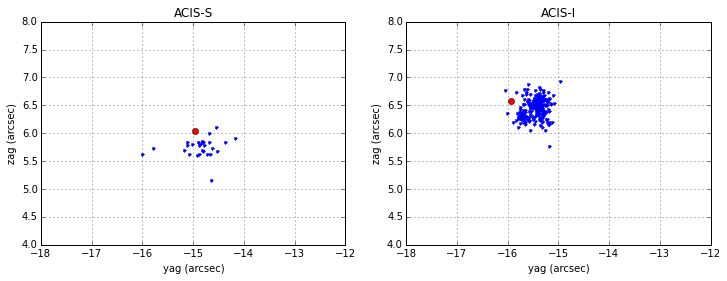

In [70]:
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plot_yag_zag(observations, 'ACIS-S')
plt.plot([-14.96], [6.04], 'or')
plt.subplot(1, 2, 2)
plot_yag_zag(observations, 'ACIS-I')
plt.plot([-15.93], [6.58], 'or')


### Use dmcoords to relate detector, dy, dz to chipx, chipy

This will be an approximation that applies over small displacements (of order 100 pixels).

In [35]:
ciaoenv = Ska.Shell.getenv('source /soft/ciao/bin/ciao.sh')

In [36]:
dmcoords_cmd = ['dmcoords', 'none',
                'asolfile=none',
                'detector=acis',
                'opt=cel',
                'ra={ra}', 
                'dec={dec}',
                'celfmt=deg', 
                'ra_nom=0',
                'dec_nom=0',
                'roll_nom=0',  
                'ra_asp=")ra_nom"',
                'dec_asp=")dec_nom"',
                'roll_asp=")roll_nom"',      
                'sim="{simx} 0 {simz}"',
                'displace="0 {dy} {dz} 0 0 0"',       
                'verbose=0']
dmcoords_cmd = ' '.join(dmcoords_cmd)

In [37]:
ciaorun = functools.partial(Ska.Shell.bash, env=ciaoenv)

In [38]:
def dmcoords_chipx_chipy(det, dy, dz):
    ra0, dec0 = -15.5 / 3600., 6.0 / 3600.
    ciaorun('punlearn dmcoords')
    ciaorun(dmcoords_cmd.format(ra=ra0, dec=dec0, 
                                simx=sim_x_nom[det], simz=sim_z_nom[det],
                                dy=dy, dz=dz))
    return [float(x) for x in ciaorun('pget dmcoords chipx chipy')]

In [39]:
def get_dy_dz(obsid):
    asolfiles = asp_l1.get_files(obsid=obsid, content=['ASPSOL'])
    asol = Table.read(asolfiles[0])
    min_dy, median_dy, max_dy = (np.min(asol['dy']), 
                              np.median(asol['dy']),
                              np.max(asol['dy']))
    min_dz, median_dz, max_dz = (np.min(asol['dz']), 
                              np.median(asol['dz']),
                              np.max(asol['dz']))
    return min_dy, median_dy, max_dy, min_dz, median_dz, max_dz                                 

In [40]:
dmcoords_chipx_chipy(det='ACIS-I', dy=-1.13993, dz=-0.99711)

[930.291070422303, 1010.649306858594]

In [41]:
dati['obsid', 'year'][:4]

obsid,year
float64,float64
5480.0,2006.10266
5481.0,2006.103003
5482.0,2006.103326
5483.0,2006.10365


In [42]:
min_dy, median_dy, max_dy, min_dz, median_dz, max_dz = get_dy_dz(5480)
print dmcoords_chipx_chipy(det='ACIS-I', dy=-median_dy, dz=-median_dz)

[946.9210940108986, 980.665361606694]


In [43]:
dats['obsid', 'year'][:4]

obsid,year
float64,float64
6730.0,2006.355317
7498.0,2007.512553
7638.0,2007.793858
8038.0,2007.139164


In [44]:
min_dy, median_dy, max_dy, min_dz, median_dz, max_dz = get_dy_dz(6730)
print dmcoords_chipx_chipy(det='ACIS-S', dy=-median_dy, dz=-median_dz)

[234.0630114424543, 493.0024357771581]


In [45]:
det = 'ACIS-I'
cx11, cy11 = dmcoords_chipx_chipy(det=det, dy=-1.0, dz=-1.0)
cx01, cy01 = dmcoords_chipx_chipy(det=det, dy=0.0, dz=-1.0)
cx12, cy12 = dmcoords_chipx_chipy(det=det, dy=-1.0, dz=-2.0)
print cx11, cy11
print cx01, cy01
print cx12, cy12

930.170576995 1004.80811033
930.171577731 963.06656217
888.428895388 1004.70371797


In [46]:
print('chipx = {:.2f} + {:.2f} * dz'.format((cx01 - cx12) + cx01, cx01 - cx12))
print('chipy = {:.2f} - {:.2f} * dy'.format(cy01, -(cy01 - cy11)))

chipx = 971.91 + 41.74 * dz
chipy = 963.07 - 41.74 * dy


In [47]:
det = 'ACIS-S'
cx11, cy11 = dmcoords_chipx_chipy(det=det, dy=-1.0, dz=-1.0)
cx01, cy01 = dmcoords_chipx_chipy(det=det, dy=0.0, dz=-1.0)
cx12, cy12 = dmcoords_chipx_chipy(det=det, dy=-1.0, dz=-2.0)
print cx11, cy11
print cx01, cy01
print cx12, cy12

210.563335767 478.300125421
252.25261612 478.27803396
210.541239861 436.610882931


In [48]:
print('chipx = {:.2f} + {:.2f} * dy'.format(cx01, cx01 - cx11))
print('chipy = {:.2f} + {:.2f} * dz'.format(cy01 + (cy01 - cy12), cy01 - cy12))

chipx = 252.25 + 41.69 * dy
chipy = 519.95 + 41.67 * dz
